# Customer Relationship Prediction


In this project, I focused on predicting three key customer behaviors:

- Churn: The likelihood that a customer will leave the company or switch to a competitor
- Appetency: The probability that a customer will purchase additional products or services
- Upselling: The tendency of a customer to buy upgrades or add-ons to an existing product

My goal was to help businesses improve customer retention by developing predictive models for churn, appetency, and up-selling. By accurately predicting these behaviors, businesses can implement targeted marketing strategies to retain at-risk customers and offer relevant products to those most likely to purchase.

I worked with the [**KDD Cup 2009** dataset](https://kdd.org/kdd-cup/view/kdd-cup-2009/Intro), provided by Orange, a French telecom company. This dataset includes both numerical and categorical data, and class imbalance. My approach involved applying machine learning techniques such as Random Forest and Logistic Regression to predict customer behaviors.

# 1. Understanding the Data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt  
import pandas as pd  
import seaborn as sns 
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score

from imblearn.under_sampling import RandomUnderSampler
from feature_engine.encoding import CountFrequencyEncoder

warnings.simplefilter("ignore", category=UserWarning)

#Importing data
df_train = pd.read_csv('orange_small_train.data', delimiter='\t')

I will use only the file 'orange_small_train.data' in this project and split it into training and testing sets later. The file 'orange_small_test.data' is very similar, but I decided not to include it to avoid the computational challenges of working with a larger dataset.

Now I will check the first and last rows in the combined dataframe. 

In [3]:
df_train.head(2) 

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN


In [4]:
df_train.tail(2)


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
49998,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,oslk,2fF2Oqu,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
49999,NaN,NaN,NaN,NaN,NaN,1694.0,7.0,NaN,NaN,NaN,...,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN


As we can see, the dataset has a lot of NaN and the features are redated, which makes the problem more challenging.

In [5]:
# Print the number of rows and columns of the dataframe
print("Shape of the dataframe:", df_train.shape)

# Get the unique data types in the dataframe
print("\nUnique data types in the dataframe:", df_train.dtypes.unique())

Shape of the dataframe: (50000, 230)

Unique data types in the dataframe: [dtype('float64') dtype('int64') dtype('O')]


The total size of the dataset has 230 columns, making it the largest dataset I have worked with so far. Let's take a look the categorical columns in the dataset. 

In [6]:
categorical_columns = df_train.select_dtypes(include=['object', 'category'])

print("Categorical columns and their unique categories count:")
for column in categorical_columns.columns:
    unique_count = categorical_columns[column].nunique()
    print(f"{column}: {unique_count} unique categories")

Categorical columns and their unique categories count:
Var191: 1 unique categories
Var192: 361 unique categories
Var193: 51 unique categories
Var194: 3 unique categories
Var195: 23 unique categories
Var196: 4 unique categories
Var197: 225 unique categories
Var198: 4291 unique categories
Var199: 5073 unique categories
Var200: 15415 unique categories
Var201: 2 unique categories
Var202: 5713 unique categories
Var203: 5 unique categories
Var204: 100 unique categories
Var205: 3 unique categories
Var206: 21 unique categories
Var207: 14 unique categories
Var208: 2 unique categories
Var210: 6 unique categories
Var211: 2 unique categories
Var212: 81 unique categories
Var213: 1 unique categories
Var214: 15415 unique categories
Var215: 1 unique categories
Var216: 2016 unique categories
Var217: 13990 unique categories
Var218: 2 unique categories
Var219: 22 unique categories
Var220: 4291 unique categories
Var221: 7 unique categories
Var222: 4291 unique categories
Var223: 4 unique categories
Var224:

It seems that the number of categories varies a lot within the categorical columns. I'll need to handle this later. As a final step in this section, I will look at our labels (target variables). 

In [7]:
labels_churn = pd.read_csv("orange_small_train_churn.labels", header=None, names=['Label_Churn'])
labels_appetency = pd.read_csv("orange_small_train_appetency.labels", header=None, names=['Label_Appetency'])
labels_upselling = pd.read_csv("orange_small_train_upselling.labels", header=None, names=['Label_Upselling'])

The link for the labels is not working anymore. I found the labels from this [github repository](https://github.com/mrmaheshrajput/kdd2009/tree/master).

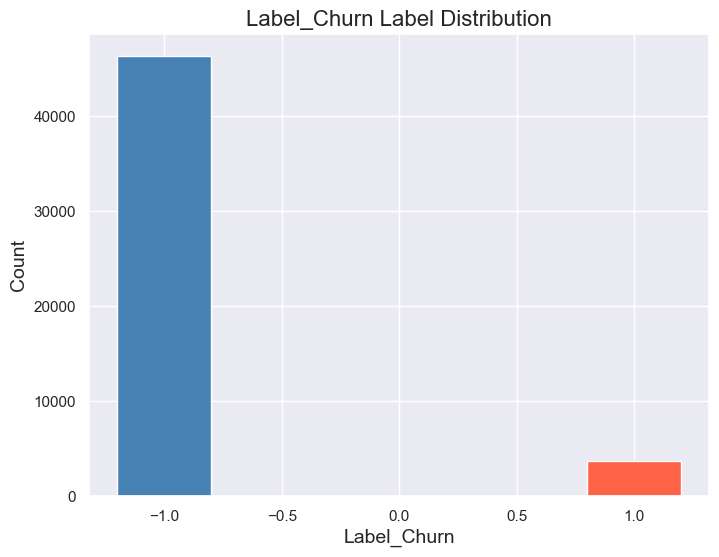

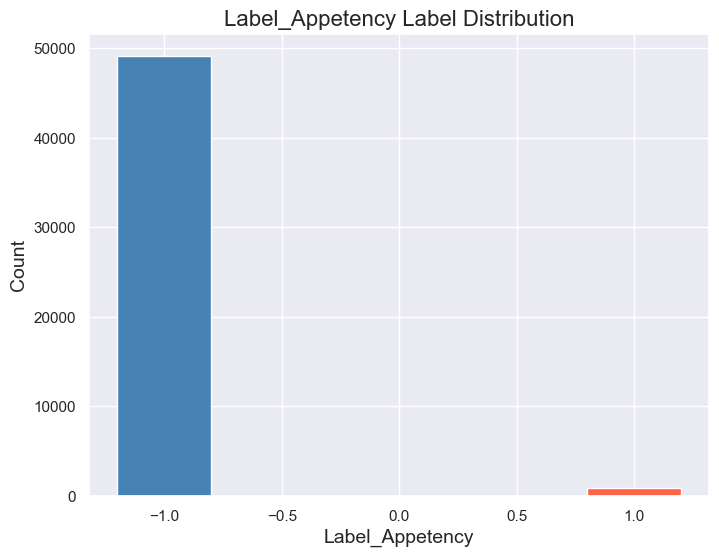

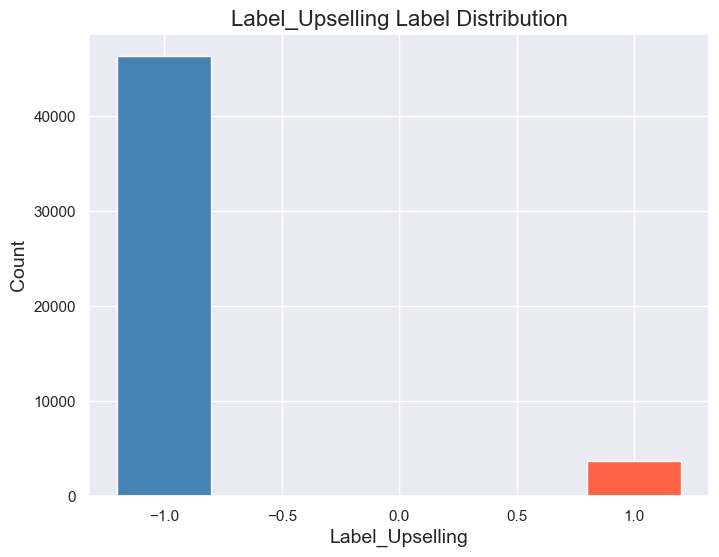

In [8]:
def plot_label_distribution(labels, label_column):
    # Count the occurrences of each class in the specified label column
    label_counts = labels[label_column].value_counts()
    colors = ['#4682B4','#FF6347']
 
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.index, label_counts.values, color=colors, width=0.4)

    # Add titles and labels
    plt.title(f'{label_column} Label Distribution', fontsize=16)
    plt.xlabel(label_column, fontsize=14)
    plt.ylabel('Count', fontsize=14)


# Example of how to use the function for different labels
plot_label_distribution(labels_churn, 'Label_Churn')
plot_label_distribution(labels_appetency, 'Label_Appetency')
plot_label_distribution(labels_upselling, 'Label_Upselling')

The figures have shown that the labels are highly unblanaced, which may affect the performance of the model. I'll deal with this later. Now let's dive into the data processing.

# 2. Data Preprocessing

First, I will remove empty columns. 

In [9]:
df_train.dropna(how='all', axis=1, inplace=True)
print("Size of the dataframe after dropping empty columns and rows:", df_train.shape)


Size of the dataframe after dropping empty columns and rows: (50000, 212)


Now I will investigate the presente of NaNs in the dataset. First, I will calculate the percentage of NaNs compared to the total number of entries.

In [10]:
# Calculate the number of NaNs
num_nans = df_train.isnull().sum().sum()

# Calculate the total number of entries
total_entries = df_train.size

print(f'Number of NaNs: {num_nans}')
print(f'Total number of entries: {total_entries}')


Number of NaNs: 7124152
Total number of entries: 10600000


I'm actually surprise that the number of NaNs is so high. To get a better understanding of the data, I will check the number of NaNs per column and plot the percentage. 

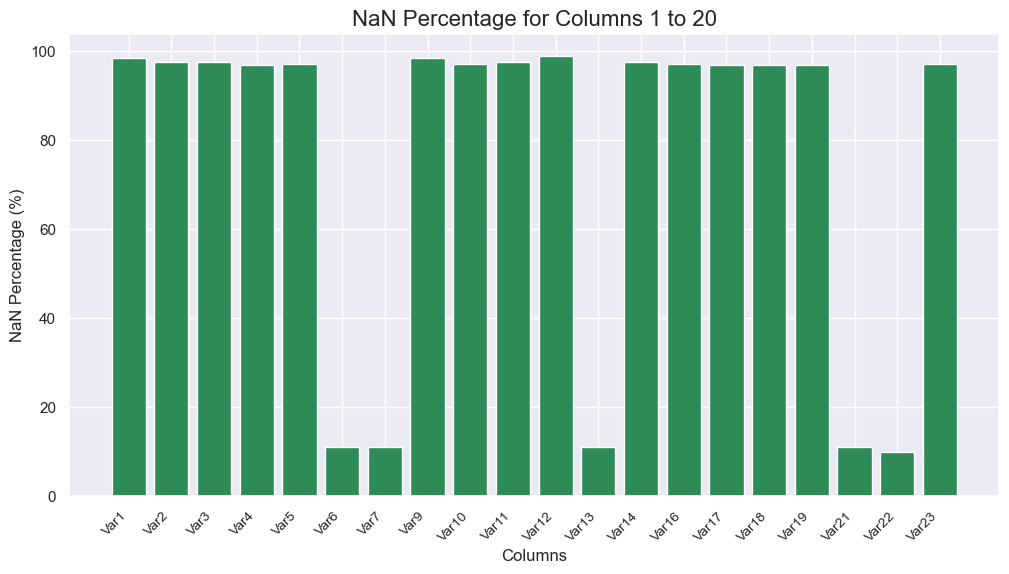

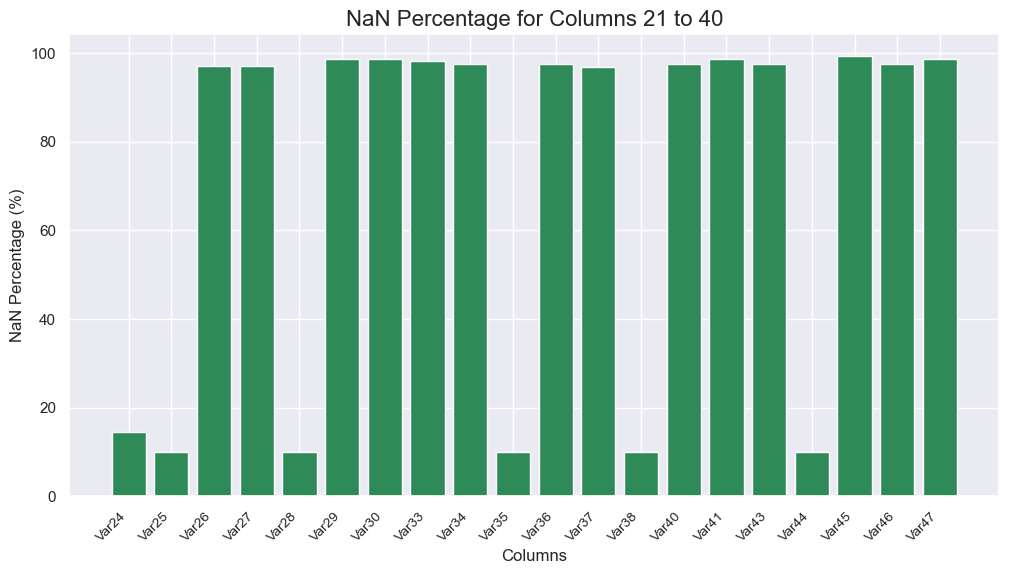

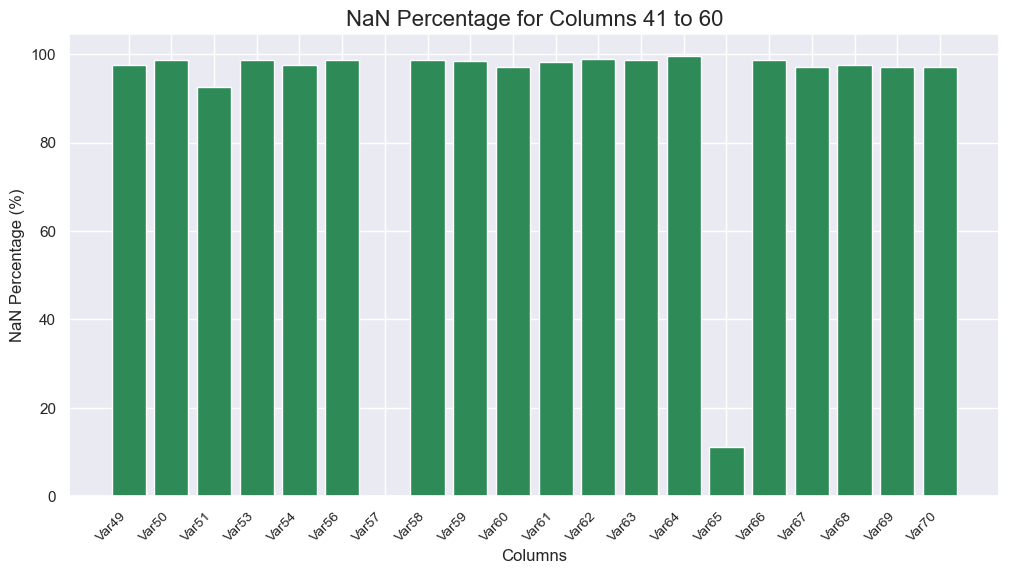

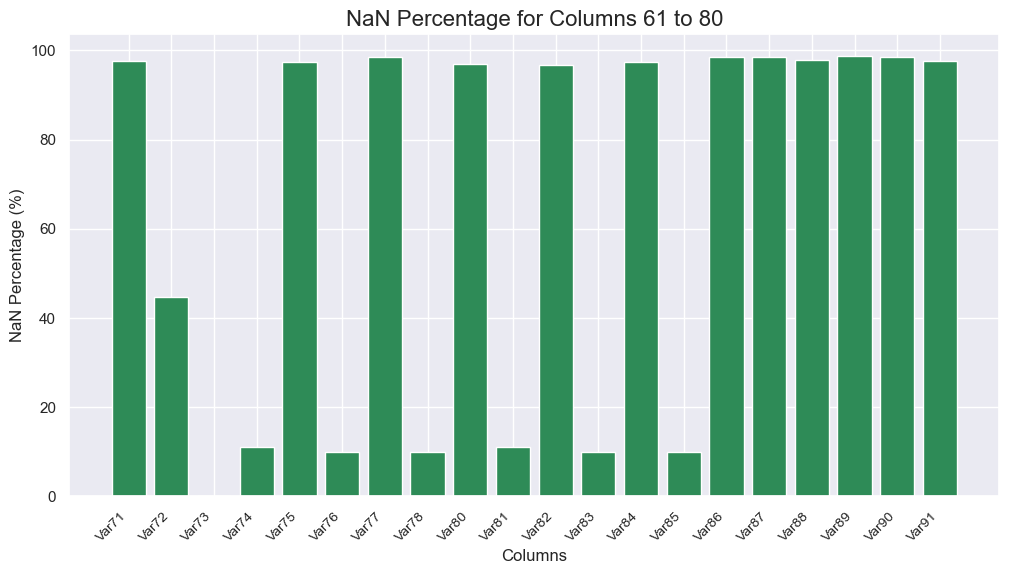

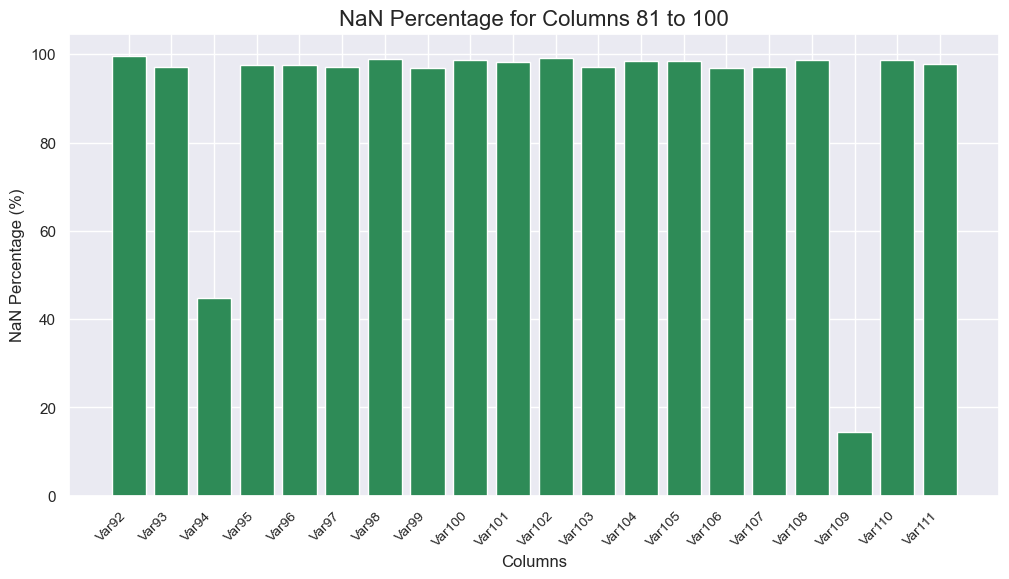

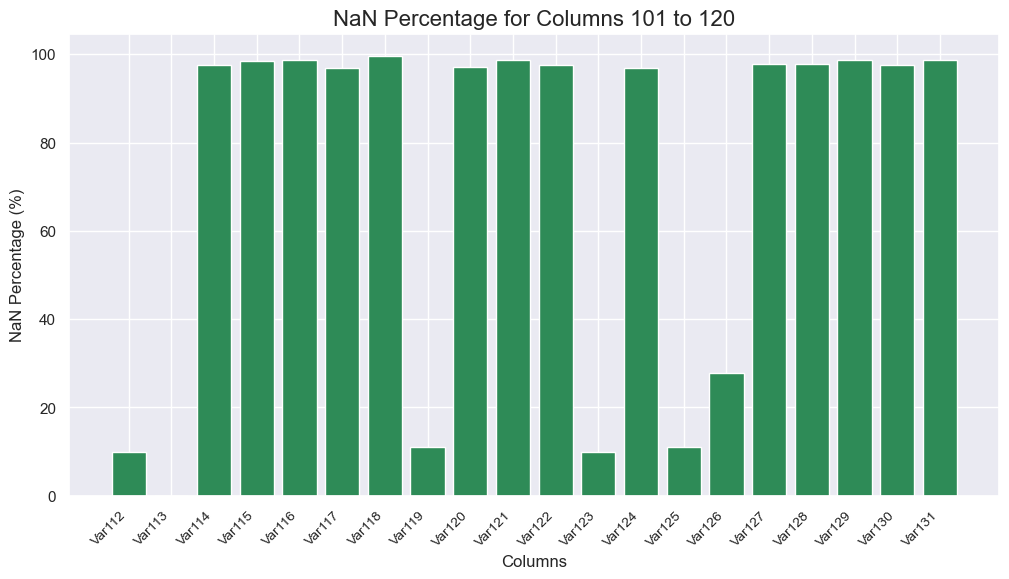

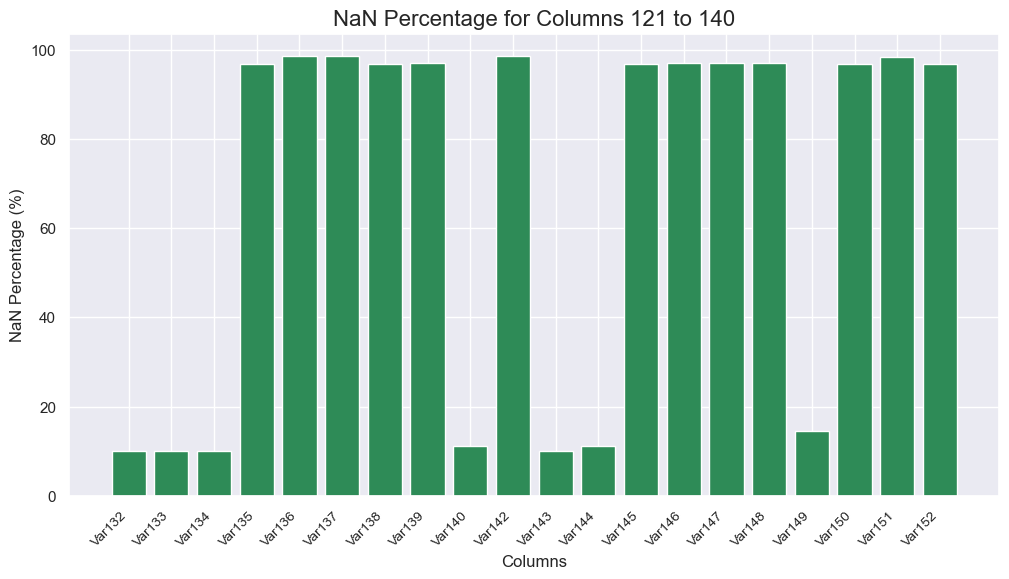

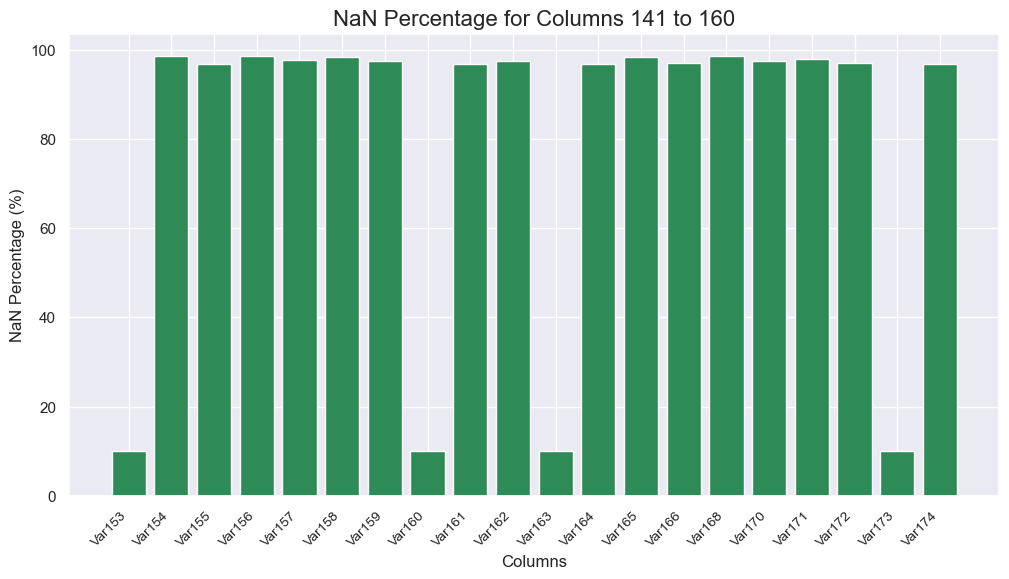

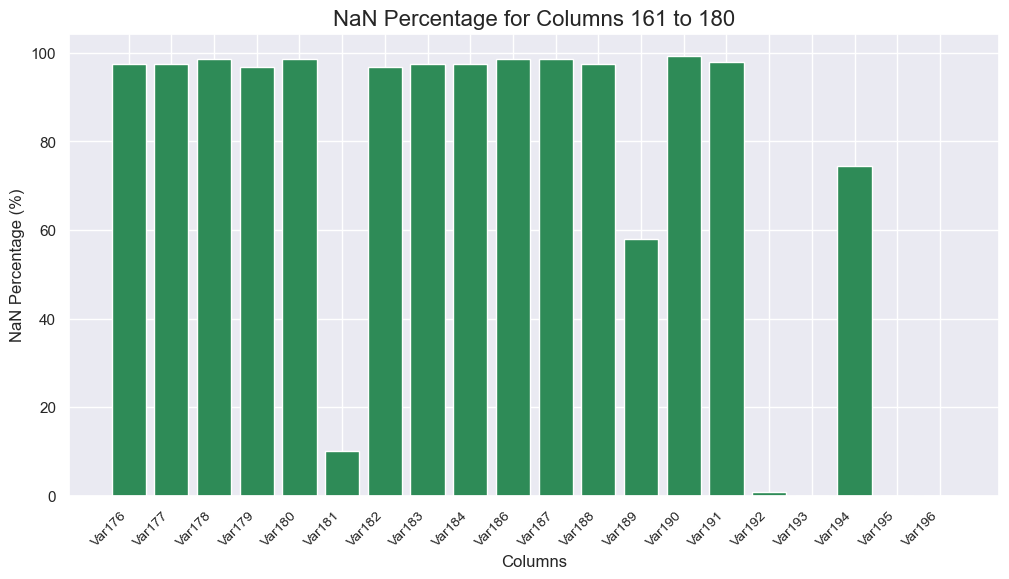

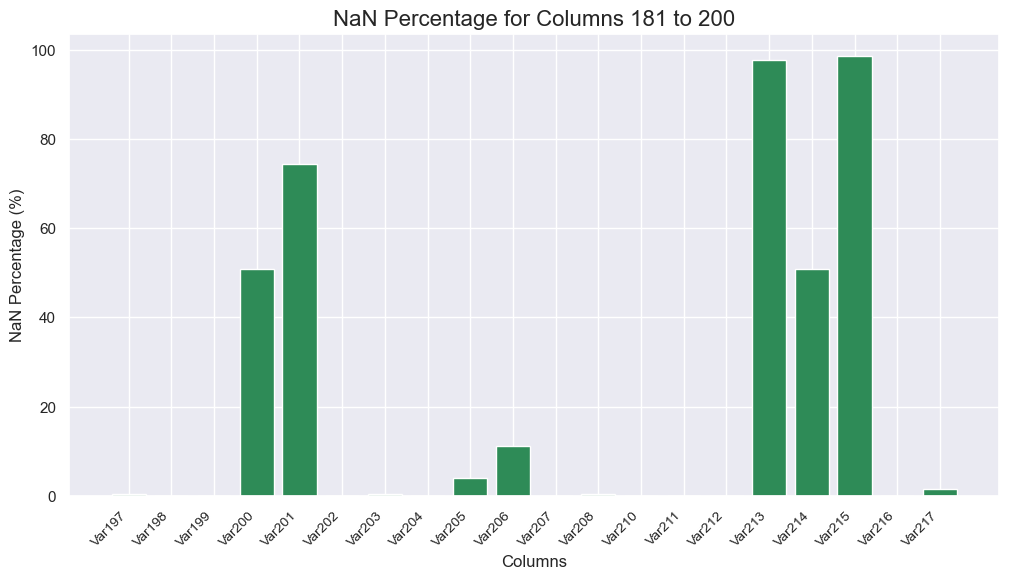

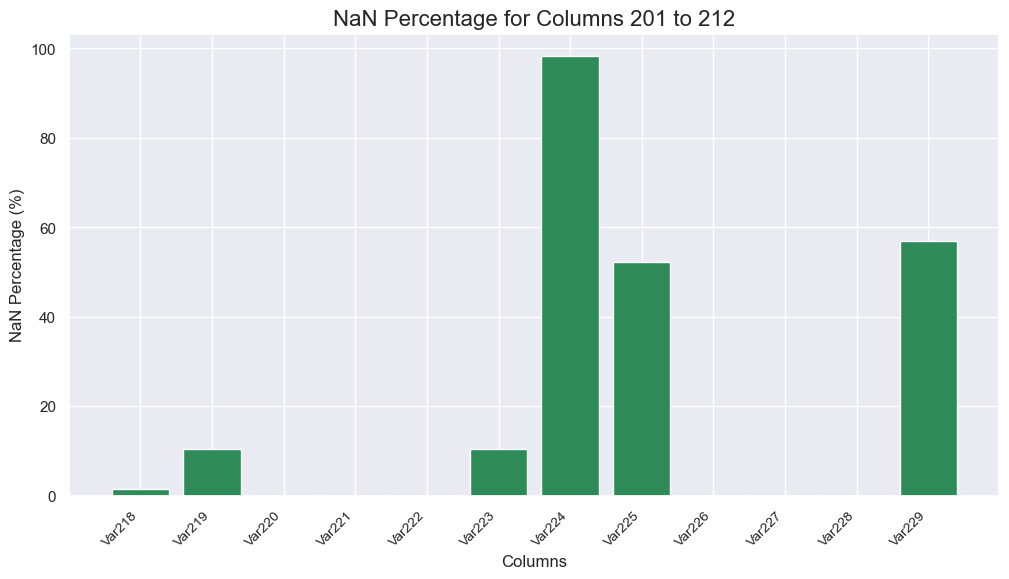

In [11]:
def plot_nan_percentage_matplotlib(nan_percentage_col, columns_per_figure):
    total_columns = len(nan_percentage_col)

    for i in range(0, total_columns, columns_per_figure):
        subset_columns = nan_percentage_col.index[i:i + columns_per_figure]
        subset_percentages = nan_percentage_col.values[i:i + columns_per_figure]
        
        plt.figure(figsize=(12, 6)) 
        
        x = np.arange(len(subset_columns))
        plt.bar(x, subset_percentages, color="seagreen")
        
        plt.title(f'NaN Percentage for Columns {i+1} to {min(i + len(subset_columns), total_columns)}', fontsize=16)
        plt.xlabel('Columns', fontsize=12)
        plt.ylabel('NaN Percentage (%)', fontsize=12)
        plt.xticks(x, subset_columns, rotation=45, ha='right', fontsize=10)

# Calculate NaN count and percentage for each column
nan_count_col = df_train.isna().sum()
total_entries_col = df_train.shape[0]
nan_percentage_col = (nan_count_col / total_entries_col) * 100

# Set max number of columns per figure to improve readbility
columns_per_figure = 20
plot_nan_percentage_matplotlib(nan_percentage_col, columns_per_figure)


The figures above show that many columns have a high number of missing values (NaN). After examining the distribution of missing data across the 230 columns, I couldn’t find any clear pattern. Because of this, I’ll assume the missing values are Missing Completely at Random (MCAR). 

To handle the missing data in this project, I first calculate the percentage of missing values for each column. Based on this, I will define a threshold to drop columns with a high proportion of missing values. It's important to note that the threshold is not standardized and varies depending on the dataset, the goals of the analysis, and other factors specific to the project.

In [12]:
def missing_value_summary(df):
    nan_percentage_col = df.isna().mean() * 100
    
    nan_summary = pd.DataFrame({
        'column': df.columns,
        'nan_percentage': nan_percentage_col
    })
    
    nan_summary_sorted = nan_summary.sort_values(by='nan_percentage', ascending=False)
    up_to_20_percent_group = nan_summary_sorted[nan_summary_sorted['nan_percentage'] <= 20]
    between_20_and_50_percent_group = nan_summary_sorted[(nan_summary_sorted['nan_percentage'] > 20) & (nan_summary_sorted['nan_percentage'] <= 50)]
    above_50_percent_group = nan_summary_sorted[nan_summary_sorted['nan_percentage'] > 50]
    
    count_up_to_20 = up_to_20_percent_group.shape[0]
    count_between_20_and_50 = between_20_and_50_percent_group.shape[0]
    count_above_50 = above_50_percent_group.shape[0]
    
    categories = ['Up to 20%', 'Between 20% and 50%', 'Above 50%']
    counts = [count_up_to_20, count_between_20_and_50, count_above_50]

    return counts, categories

counts_col,groups_col=missing_value_summary(df_train)

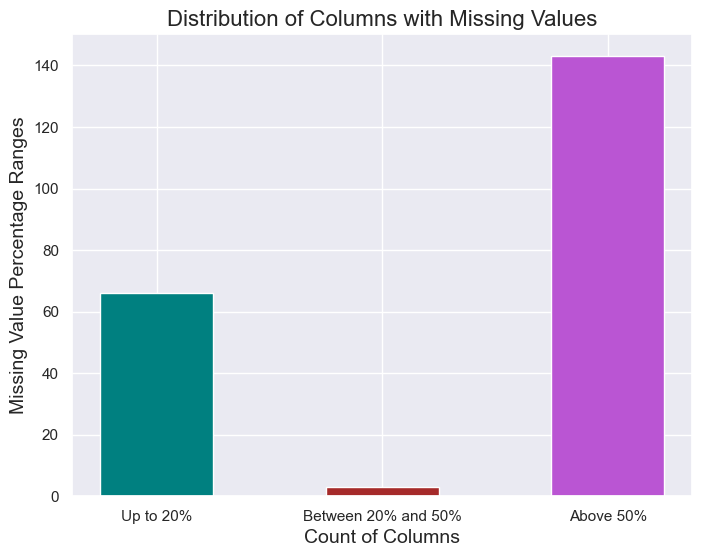

In [13]:
def plot_missing_values_distribution(counts, groups):
    colors = ['teal', 'brown', 'mediumorchid']
    plt.figure(figsize=(8, 6))
    plt.bar(groups, counts, color=colors,width=0.5)
    plt.title('Distribution of Columns with Missing Values', fontsize=16)
    plt.xlabel('Count of Columns', fontsize=14)
    plt.ylabel('Missing Value Percentage Ranges', fontsize=14)

plot_missing_values_distribution(counts_col, groups_col)

The number of columns with missing values above 50% is above 140, which is very high. In this case, using an imputation method may not be beneficial. Considering that there are 66 columns with up to 20% of missing values, I think it could be an appropriate threshold to the problem.

I will create a copy of the original dataframe to preserve the integrity of the original data. This approach allows me to keep the original dataset intact, making it easier to compare results later if needed.

In [14]:
df_clean=df_train.copy()
df_clean.dropna(axis=1, thresh=(len(df_train) * 0.8), inplace=True)
df_clean.shape

(50000, 66)

Let's check to see if the count of numerical and categorial columns after the cleaning. 

In [15]:
def column_summary(df):
    numerical_cols = df.select_dtypes(include=['number']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    return numerical_cols,categorical_cols

num_cols,cat_cols=column_summary(df_clean)
print(f'Number of numerical columns after the data cleaning: {len(num_cols)}')
print(f'Number of categorical columns after the data cleaning: {len(cat_cols)}')

Number of numerical columns after the data cleaning: 38
Number of categorical columns after the data cleaning: 28


Let's look to the count of missing values in the remain 66 features.

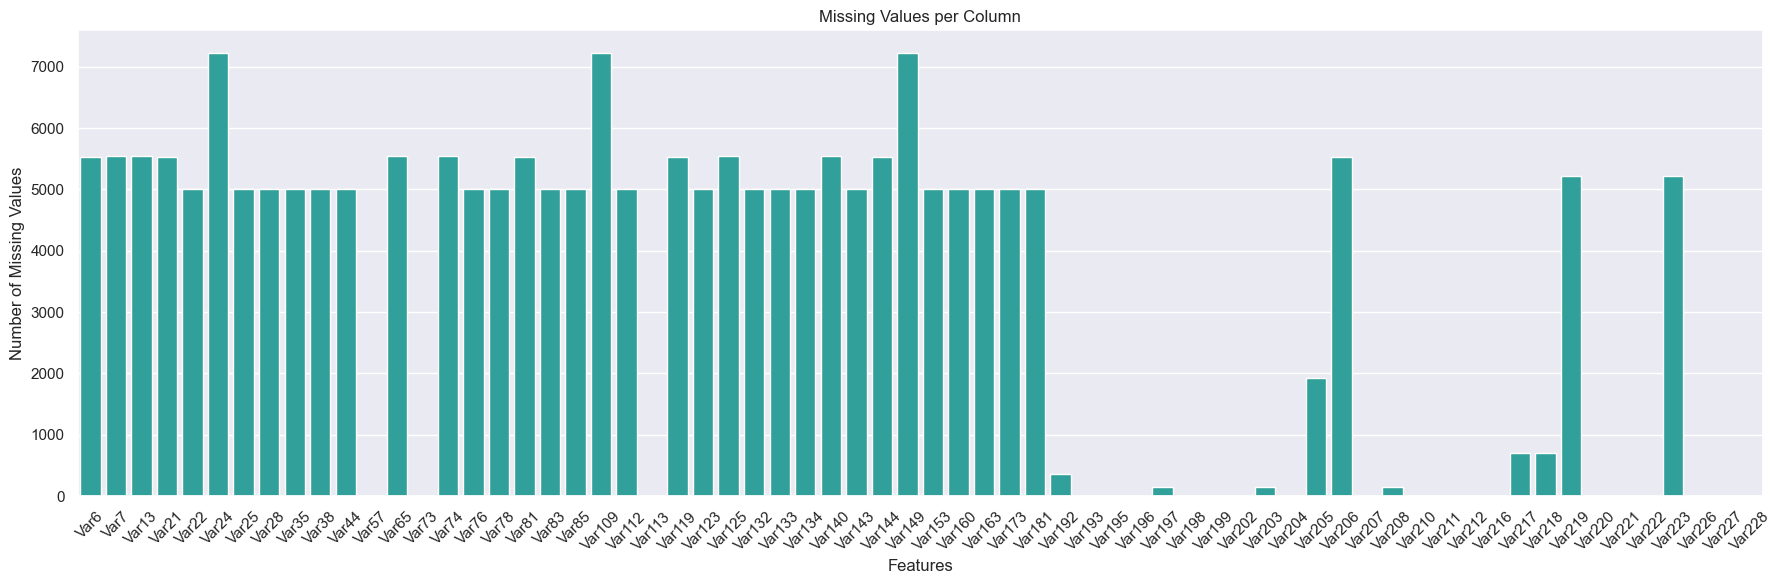

In [16]:
def missing_values_column(df):
    missing_values = df.isna().sum()

    plt.figure(figsize=(18,6))
    sns.barplot(x=missing_values.index, y=missing_values.values,color='lightseagreen')
    plt.title('Missing Values per Column')
    plt.xlabel('Features')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45)
    plt.tight_layout()

missing_values_column(df_clean)

As we can observe, there are still many missing values. Additionally, the count varies across columns, with the highest number missing values found in the numerical columns. I will also inspect possible duplicates in the dataset.

In [17]:
count_duplicates = df_clean.duplicated()
print(f"Number of duplicate rows: {count_duplicates.sum()}")

Number of duplicate rows: 0


Good news: no duplicates. However, there are still many missing values that need to be addressed. This issue can be tackled in different ways: by deleting rows with NaNs or imputing the data. 

# 3. Deleting Rows with Missing Data

This approach is straightforward, as we can use pandas to drop rows with missing values. 
- **Benefits:** It is simple to implement and does not introduce synthetic data into the dataset. 
- **Downside:** It reduces the dataset size, which may impact the analysis or model performance.

In [18]:
df_no_imputation=df_clean.copy()
indices_to_drop = df_clean[df_clean.isnull().any(axis=1)].index
df_no_imputation.drop(indices_to_drop, axis=0, inplace=True)

In [19]:
labels_churn.drop(indices_to_drop, axis=0, inplace=True)
labels_appetency.drop(indices_to_drop, axis=0, inplace=True)
labels_upselling.drop(indices_to_drop, axis=0, inplace=True)

I dropped the same rows in the test and label data. Now I will inspect if this affects the distribution of the labels.

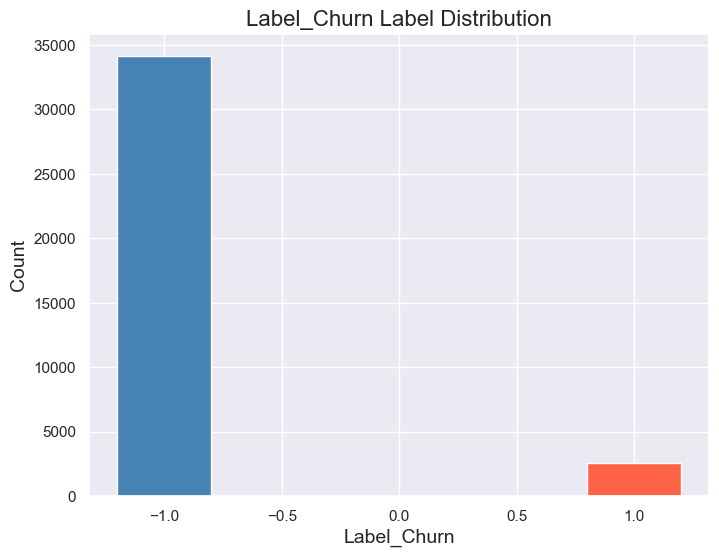

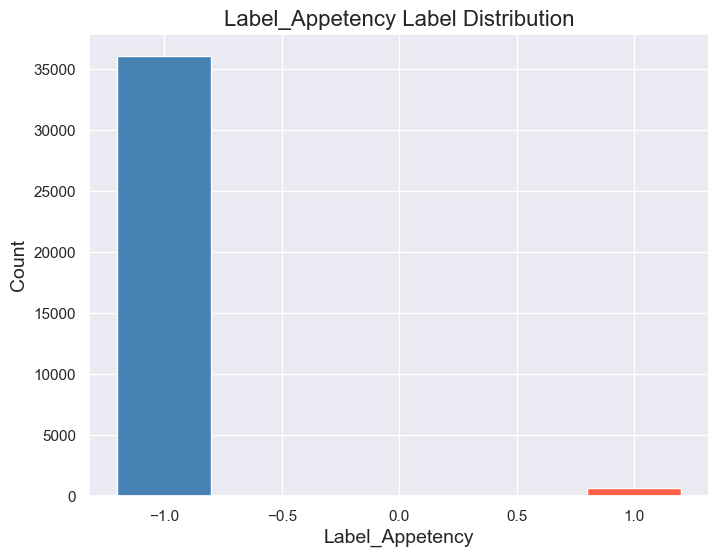

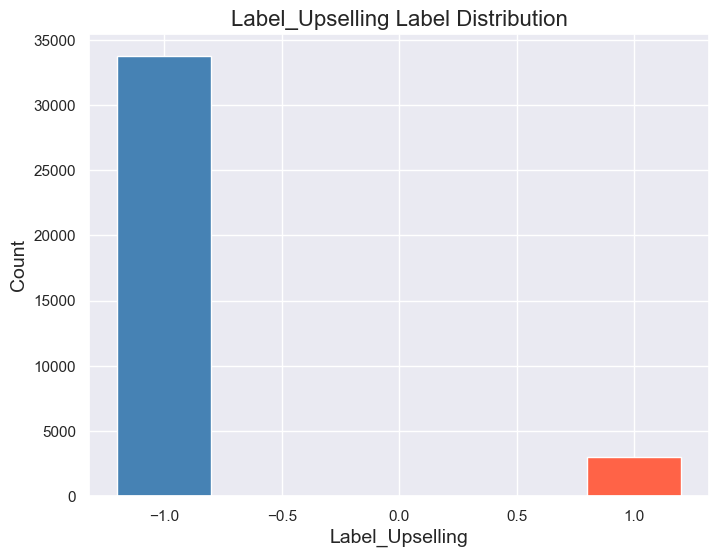

In [20]:
plot_label_distribution(labels_churn, 'Label_Churn')
plot_label_distribution(labels_appetency, 'Label_Appetency')
plot_label_distribution(labels_upselling, 'Label_Upselling')

The class imbalance is the same before and dropping the rows. So, I didn't screw up this. We can also notice that the size of the train tested was significantly reduced, but at least we remove all the empty values. Now let's check the numer of numerical and categorical columns after the cleaning.

In [21]:
num_cols_clean,cat_cols_clean=column_summary(df_no_imputation)

# 4. Handling Categorical Data

There are different approaches to manage categorical data depending on their cardinality (number of unique entries in each column). I will plot a figure to check this.

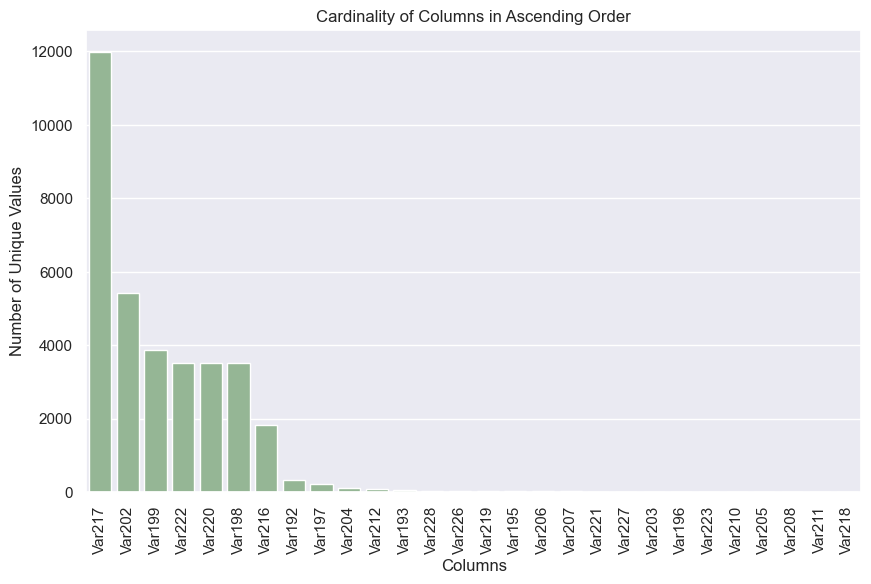

In [22]:
def plot_cardinality(cardinality_sorted):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cardinality_sorted.index, y=cardinality_sorted.values,color='darkseagreen')
    plt.title('Cardinality of Columns in Ascending Order')
    plt.xlabel('Columns')
    plt.ylabel('Number of Unique Values')
    plt.xticks(rotation=90)

cardinality_cols = df_no_imputation[cat_cols_clean].nunique()
cardinality_sorted = cardinality_cols.sort_values(ascending=False)
plot_cardinality(cardinality_sorted)

As we can see, 7 columns have a high number of cardinality (over 1500). I will drop those columns because they may introduce unnecessary complexity and noise into the model. 

In [23]:
columns_above_1500 = cardinality_sorted[cardinality_sorted > 1500].index
df_no_imputation = df_no_imputation.drop(columns=columns_above_1500)
cat_cols_updated = df_no_imputation.select_dtypes(include=['object', 'category']).columns

Let's check the shape of the dataset again. 

In [24]:
df_no_imputation.shape

(36730, 59)

There are different approaches to encode categorical data: one-hot encoding, target encoding, frequency encoding. To select the most suitable method, I read several articles at Medium and Towards Data Science. [Target versus Frequency Encoding](https://sagarikakathuria29.medium.com/understanding-the-difference-between-target-encoding-and-frequency-encoding-1d9bd264b8e)

- **One-hot encoding**: The main idea is to encode each category into its own binary column (0 or 1). But if you have a lot of categories, which is my case, it can really blow up the number of features in your dataset.

Ok, so now we now that one-hot encoding is not the best option for this problem because it will increase even more the number of features. Let's check the target encoding. 

- **Target encoding**: This method replace each category with the average value of the target for that category. 

The main problem of the target encoding is the fact that depends on the target variables. For example, in our case all the three target variables have a class imbalance. This could led to the mean target values for those categories might be biased towards the prevalent class. This can result in encoding values that are not representative of the true relationship between the category and the target variable. 

Let's check the frequency encoding. 
- **Frequency encoding**: This one replaces each category with how often it appears in the dataset without considering the target variables. 

This way we can avoid the extra features from one-hot encoding. Also, here the encoding does not depend on the target variable, so this method is safe from class imbalance. For the reasons mentioned above, I will select the frequency encoding method for this dataset.

I will implement the frequency encoding method using the [feature engine library](https://feature-engine.trainindata.com/en/latest/index.html).

In [25]:
encoder = CountFrequencyEncoder(encoding_method='frequency')
df_encoded = encoder.fit_transform(df_no_imputation[cat_cols_updated])

Since the output is a DataFrame, we can replace the original categorical columns with the encoded ones. Frequency encoding replaces each category with its frequency, so the number of columns stays the same.

In [26]:
df_no_imputation[cat_cols_updated] = df_encoded
df_no_imputation[cat_cols_updated].head()

,Var192,Var193,Var195,Var196,Var197,Var203,Var204,Var205,Var206,Var207,...,Var210,Var211,Var212,Var218,Var219,Var221,Var223,Var226,Var227,Var228
0,0.004601,0.665369,0.960387,0.992159,0.089436,0.911054,0.012742,0.674136,0.071903,0.682603,...,0.957582,0.849714,0.158454,0.517751,0.898421,0.724666,0.140348,0.042799,0.684400,0.593520
2,0.003812,0.048516,0.960387,0.992159,0.002314,0.911054,0.010237,0.674136,0.071903,0.062374,...,0.957582,0.849714,0.013313,0.482249,0.898421,0.035339,0.140348,0.096161,0.037599,0.067411
4,0.003648,0.665369,0.960387,0.992159,0.004138,0.911054,0.031228,0.087803,0.028042,0.682603,...,0.957582,0.849714,0.158454,0.482249,0.898421,0.724666,0.806071,0.157310,0.684400,0.593520
5,0.006262,0.181650,0.960387,0.992159,0.089436,0.911054,0.008848,0.674136,0.041002,0.062374,...,0.957582,0.849714,0.000027,0.482249,0.898421,0.138797,0.806071,0.043697,0.037599,0.023441
6,0.004710,0.181650,0.960387,0.992159,0.007215,0.911054,0.021345,0.674136,0.071903,0.682603,...,0.957582,0.150286,0.158454,0.482249,0.898421,0.724666,0.806071,0.157310,0.684400,0.109012


Double check to make sure we handle the categorical variables

In [27]:
def cat_cols_check(df_no_imputation):
    cat_cols_check = [col for col in df_no_imputation.columns if pd.api.types.is_object_dtype(df_no_imputation[col]) or pd.api.types.is_categorical_dtype(df_no_imputation[col])]

    if cat_cols_check:
        print(f"There are {len(cat_cols_check)} categorical columns.")
    else:
        print("No categorical columns were found.")

cat_cols_check(df_no_imputation)

No categorical columns were found.


# 5. EDA 

I like to start the EDA by using the simple command describe and get a view on the data.

In [28]:
df_no_imputation.describe()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var210,Var211,Var212,Var218,Var219,Var221,Var223,Var226,Var227,Var228
count,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,3.673000e+04,...,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000,36730.000000
mean,1395.610945,7.370868,1374.029730,245.242254,306.552818,4.618405,103.515165,226.486892,0.730738,2.679439e+06,...,0.917988,0.744600,0.317040,0.500630,0.809077,0.550198,0.671923,0.067138,0.498576,0.374195
std,2715.470714,6.316328,2929.760372,570.192786,712.740982,9.940066,220.058480,96.927726,2.997394,3.014950e+06,...,0.188138,0.249945,0.236423,0.017740,0.265723,0.284214,0.274142,0.044754,0.274999,0.266117
min,0.000000,0.000000,0.000000,4.000000,5.000000,0.000000,0.000000,-66.880000,0.000000,0.000000e+00,...,0.000898,0.150286,0.000027,0.482249,0.000027,0.003022,0.004002,0.006480,0.000381,0.000027
25%,602.000000,7.000000,8.000000,124.000000,155.000000,0.000000,24.000000,166.560000,0.000000,2.022900e+04,...,0.957582,0.849714,0.034413,0.482249,0.898421,0.138797,0.806071,0.029758,0.145848,0.067411
50%,903.000000,7.000000,320.000000,148.000000,185.000000,2.000000,56.000000,220.080000,0.000000,1.555200e+06,...,0.957582,0.849714,0.533896,0.517751,0.898421,0.724666,0.806071,0.053253,0.684400,0.593520
75%,1498.000000,7.000000,1864.000000,240.000000,300.000000,6.000000,128.000000,266.400000,0.000000,4.673217e+06,...,0.957582,0.849714,0.533896,0.517751,0.898421,0.724666,0.806071,0.096161,0.684400,0.593520
max,131761.000000,140.000000,197872.000000,36272.000000,45340.000000,494.000000,13168.000000,5158.560000,60.000000,1.884690e+07,...,0.957582,0.849714,0.533896,0.517751,0.898421,0.724666,0.806071,0.157310,0.684400,0.593520


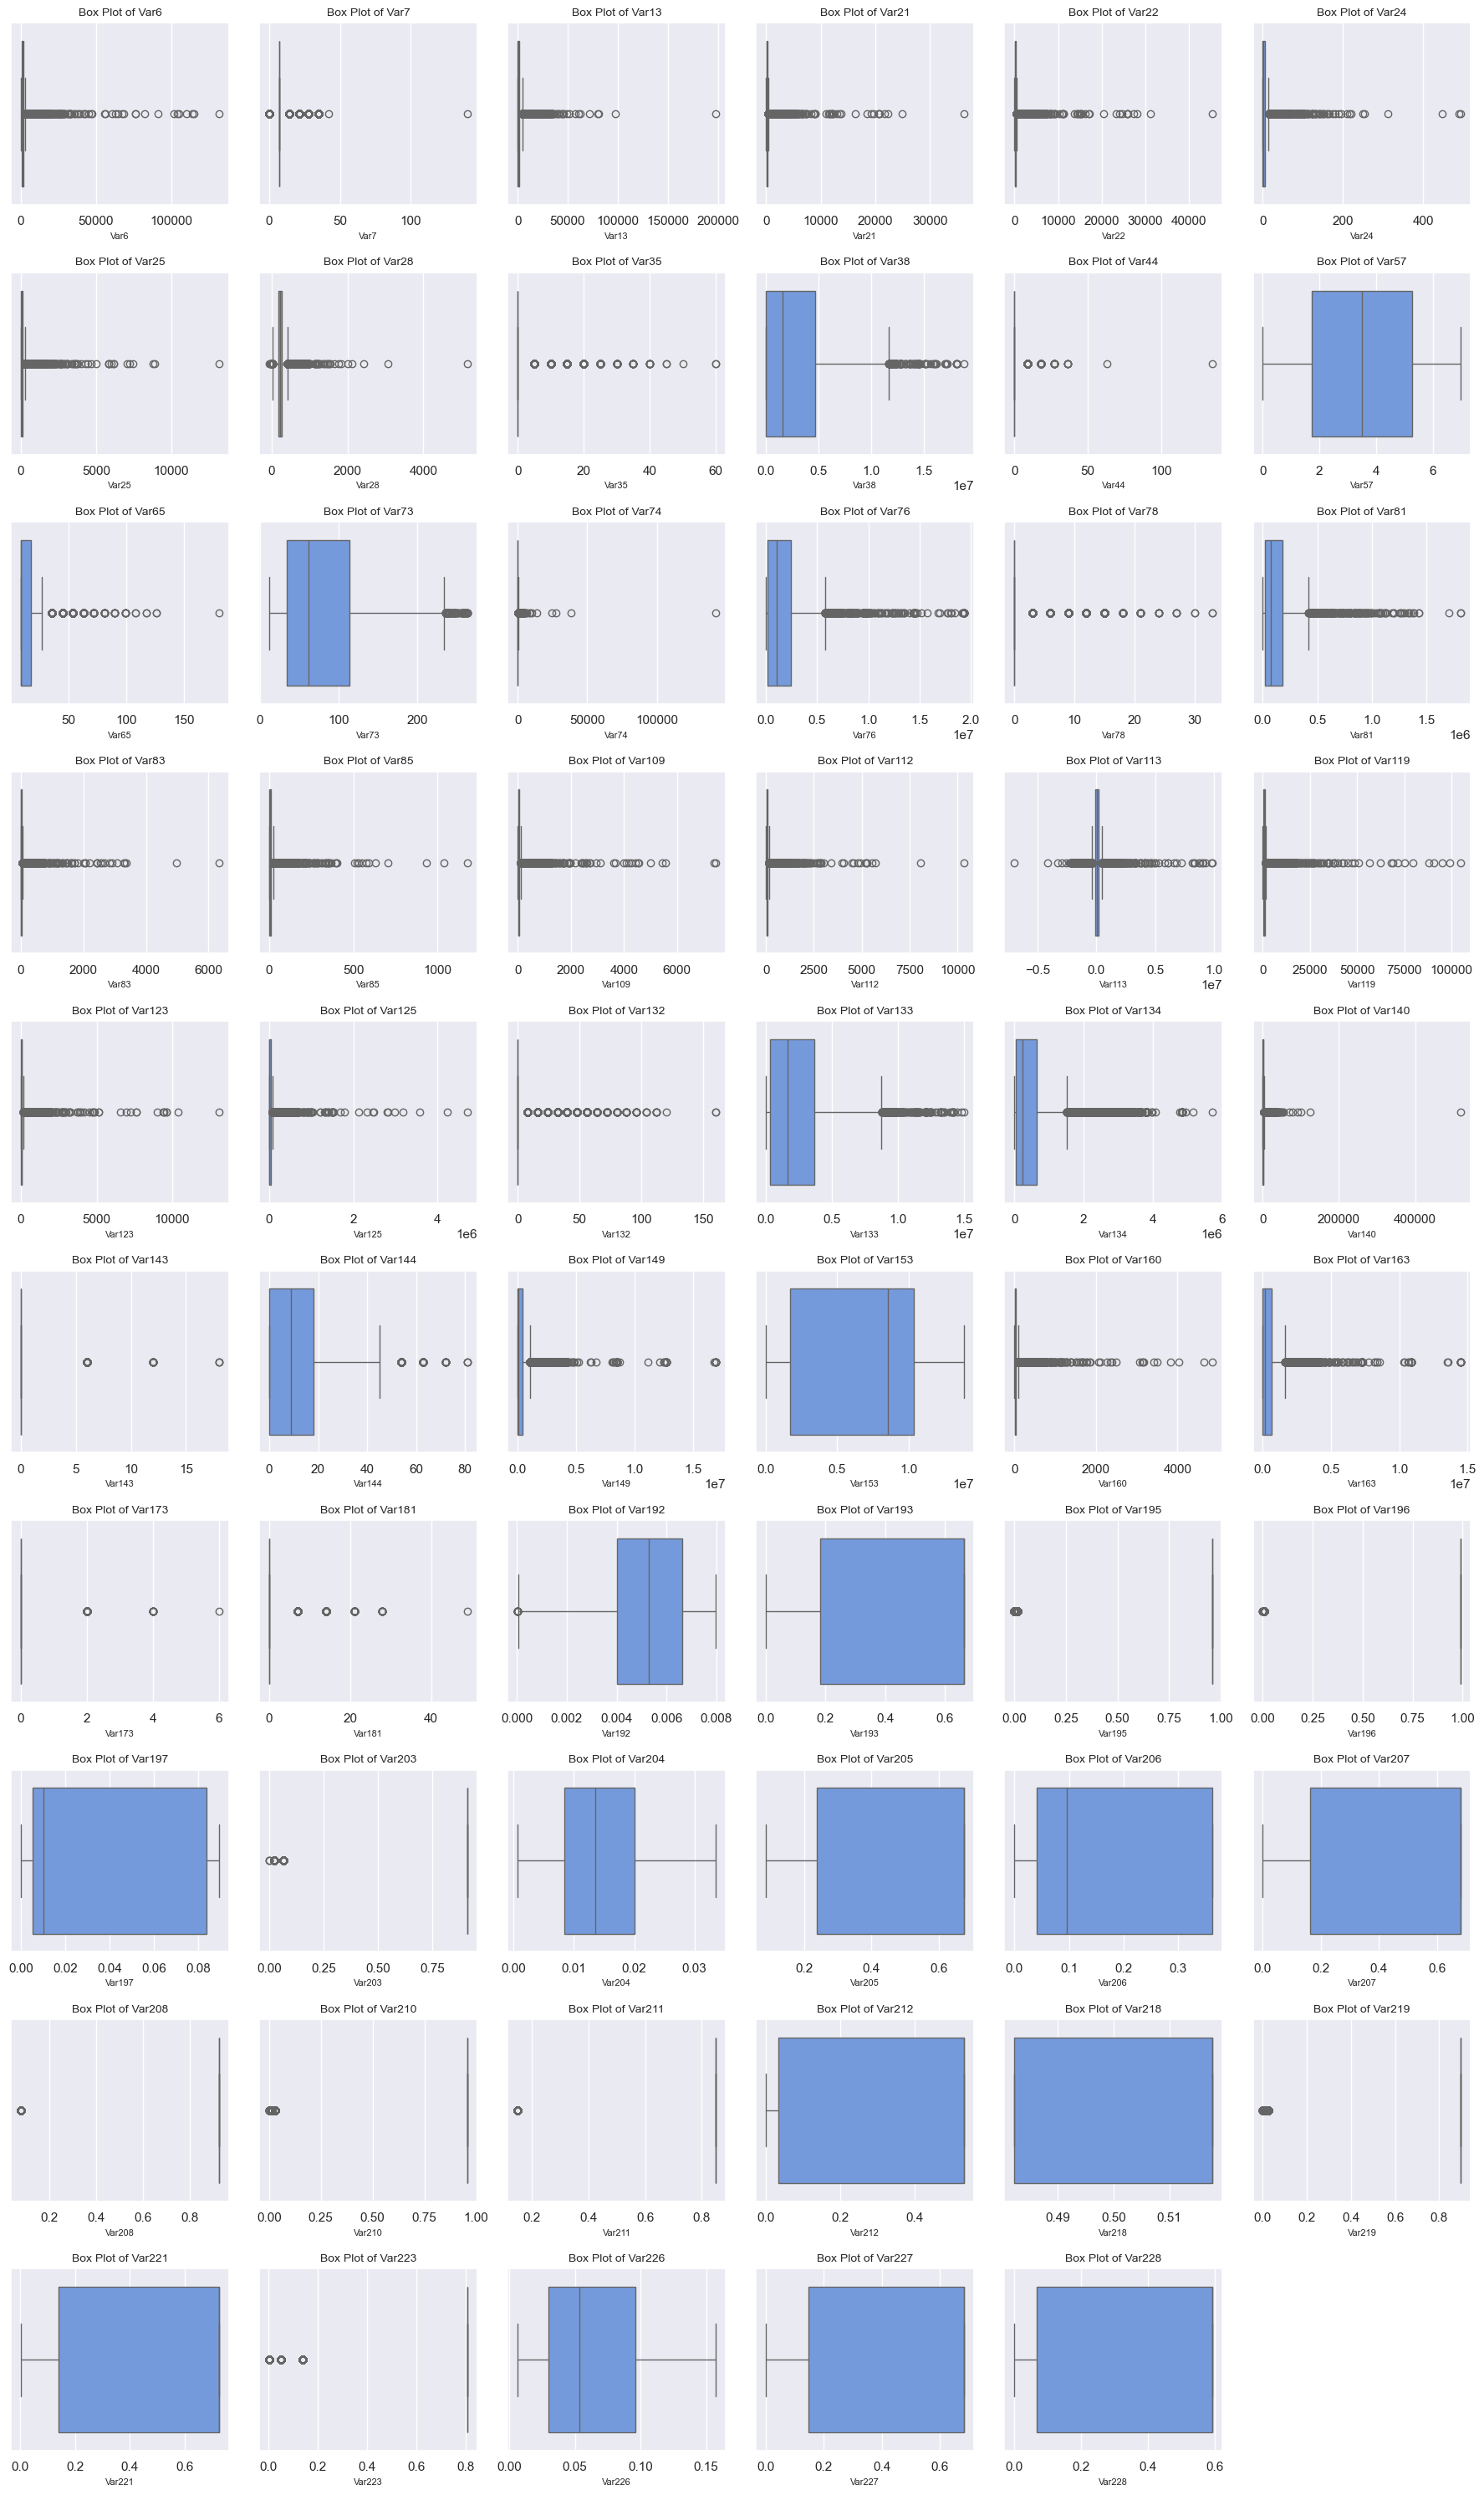

In [29]:
def df_boxplot(df_no_imputation):
    columns_to_plot = df_no_imputation.columns
    total_columns = len(columns_to_plot)
    
    nrows = (total_columns // 6) + (1 if total_columns % 6 != 0 else 0)
    ncols = 6
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 30))
    axes = axes.flatten()

    for i, col in enumerate(columns_to_plot):
        sns.boxplot(x=df_no_imputation[col], ax=axes[i], color='cornflowerblue')
        axes[i].set_title(f'Box Plot of {col}', fontsize=10)
        axes[i].set_xlabel(col, fontsize=8)
    
    for j in range(total_columns, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

df_boxplot(df_no_imputation)


Conclusions based on the boxplot of the features: 

- The features have different ranges, which makes it tricky to compare them directly

- A lot of features are sparse, with mostly zero values

- There are many outliers in the data

Next I will split the data.

In [30]:
X_train_churn, X_test_churn, y_train_churn, y_test_churn = train_test_split(df_no_imputation, labels_churn, random_state=1, test_size=0.2, stratify=labels_churn)
X_train_appet, X_test_appet, y_train_appet, y_test_appet = train_test_split(df_no_imputation, labels_appetency, random_state=1, test_size=0.2, stratify=labels_appetency)
X_train_upsel, X_test_upsel, y_train_upsel, y_test_upsel = train_test_split(df_no_imputation, labels_upselling, random_state=1, test_size=0.20, stratify=labels_upselling)

# 6. Feature Selection

This project aims to predict three distinct target variables: churn, appetency, and upselling, treating each prediction as a separate problem. Since there are many features, I will use random forest for feature selection due to its ability to handle outliers.

In [31]:
def get_features(features, targets):
    clf_tree = RandomForestClassifier(n_estimators = 200,
                                      criterion = 'entropy',
                                      n_jobs = -1, 
                                      random_state = 42)
    clf_tree.fit(features, targets.values.ravel())
    importances = clf_tree.feature_importances_
    
    variables = np.array(features.columns)
    indices = np.argsort(importances)[: : -1]
    importances = importances[indices]
    variables = variables[indices]
    
    return variables, importances

selected_features_churn, importances_churn = get_features(X_train_churn, y_train_churn)
selected_features_appet, importances_appet = get_features(X_train_appet, y_train_appet)
selected_features_upsel, importances_upsel = get_features(X_train_upsel, y_train_upsel)

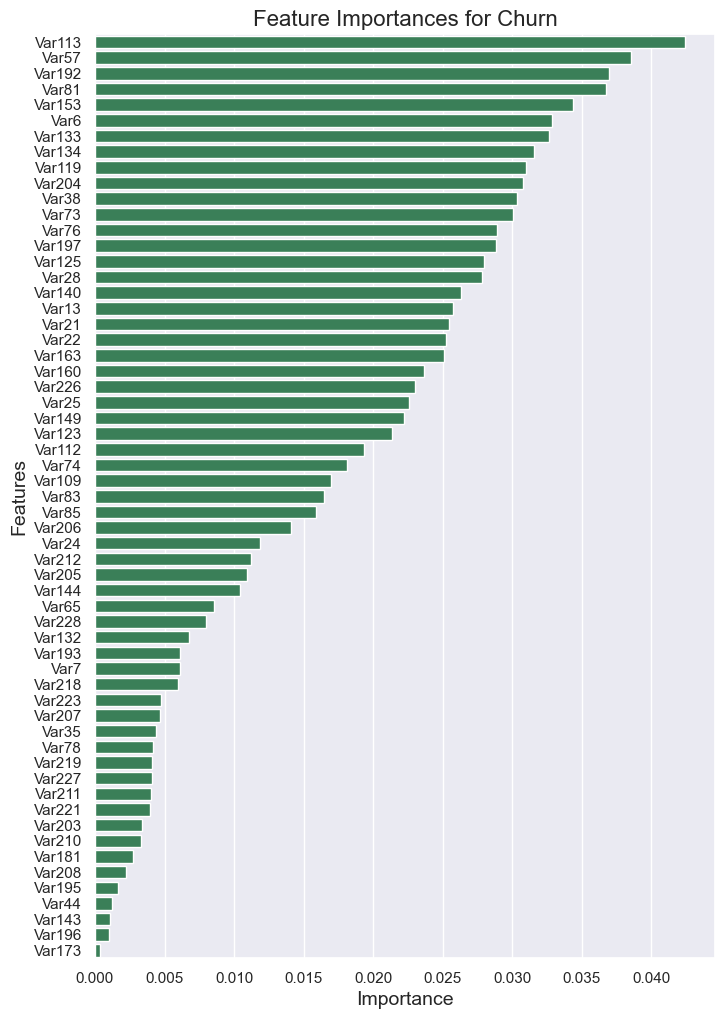

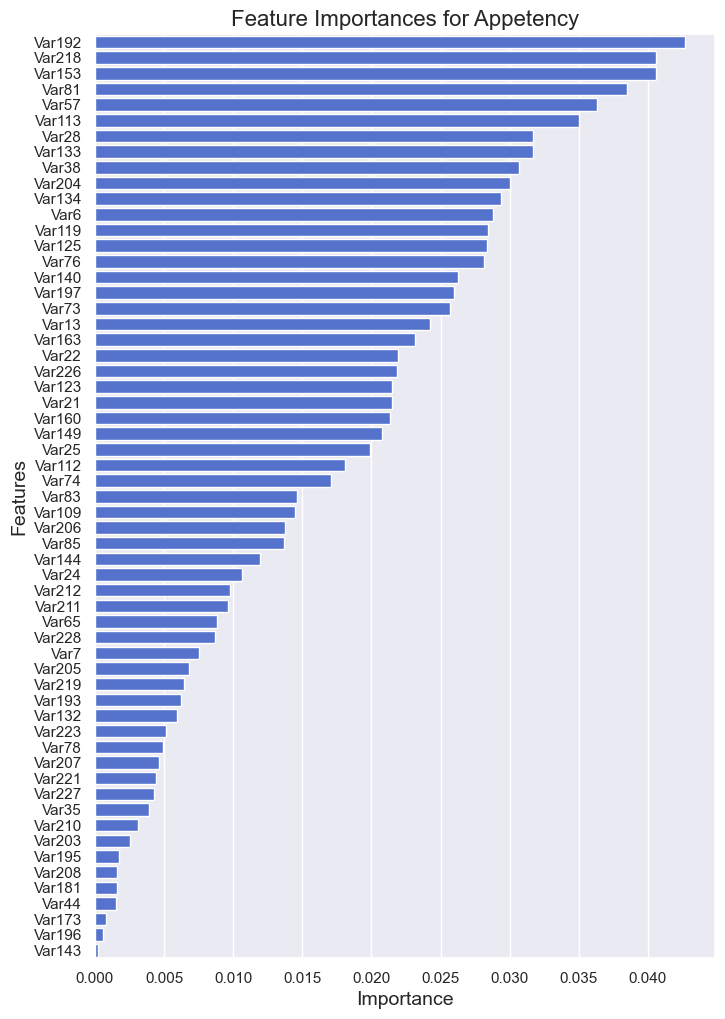

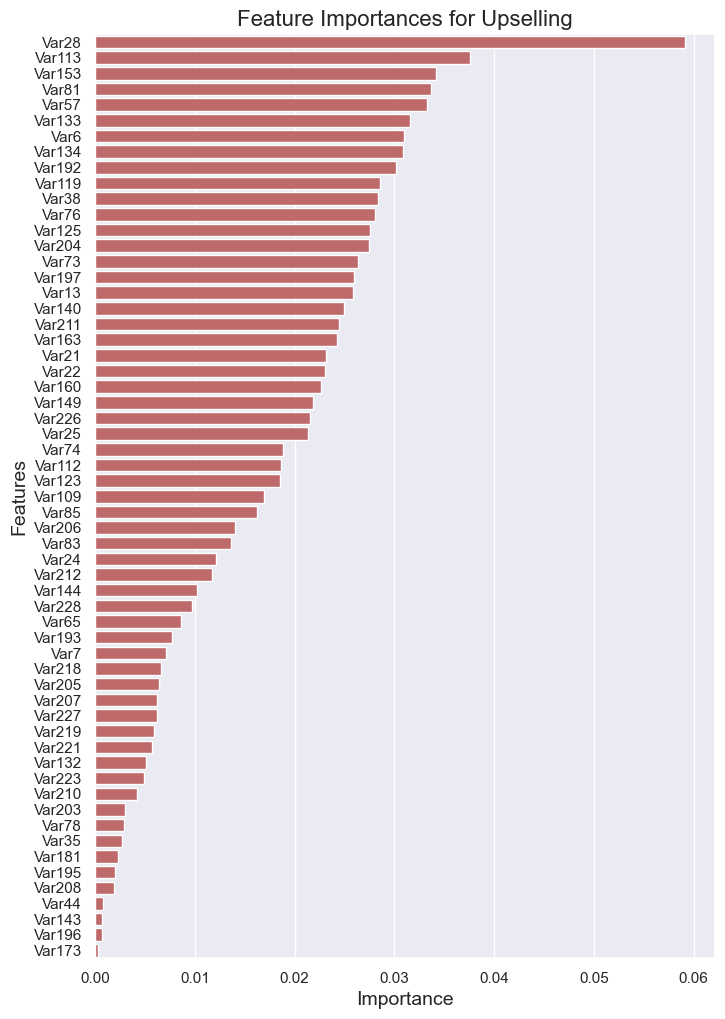

In [32]:
def plot_feature_importances(features, importances, title,select_colour):
    sorted_idx = sorted(range(len(importances)), key=lambda k: importances[k], reverse=True)
    sorted_features = [features[i] for i in sorted_idx]
    sorted_importances = [importances[i] for i in sorted_idx]
    
    # Create the bar plot
    plt.figure(figsize=(8, 12))
    sns.barplot(x=sorted_importances, y=sorted_features,color=select_colour)
    plt.title(title, fontsize=16)
    plt.xlabel("Importance", fontsize=14)
    plt.ylabel("Features", fontsize=14)

    
plot_feature_importances(selected_features_churn, importances_churn, "Feature Importances for Churn",'seagreen')
plot_feature_importances(selected_features_appet, importances_appet, "Feature Importances for Appetency",'royalblue')
plot_feature_importances(selected_features_upsel, importances_upsel, "Feature Importances for Upselling",'indianred')


As we can see, the feature importances are low. This could be related to the quality of the data and might limit the performance of our algorithm.

# 7. Modeling

I will use two methods, Random Forest and Logistic Regression, to tackle the prediction of the target variables. The metric for evaluation will be the ROC AUC score, as it effectively measures the model’s ability to distinguish between positive and negative classes.

# 7.1 Random Forest 

The first method is the Random Forest. However, our target variables are highly imbalanced, which affects its performance. To address this, I used an undersampling technique to reduce the size of the majority class and balance the dataset. I tested both oversampling and undersampling methods, and undersampling performed slightly better in this case.

In [33]:
def train_random_forest(X_train,X_test,y_train,selected_features,params):
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]  

    undersampler = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_selected, y_train)

    model = RandomForestClassifier(
        n_estimators=params.get("n_estimators"),
        max_features=params.get("max_features"),
        min_samples_leaf=params.get("min_samples_leaf"),
        n_jobs=-1,  
        class_weight="balanced",
        random_state=42,
    )

    model.fit(X_train_resampled, y_train_resampled)

    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

    return y_pred_proba

churn_params = {
    "n_estimators": 300,
    "max_features": 40,
    "min_samples_leaf": 2,
}

y_pred_churn_proba = train_random_forest(
    X_train=X_train_churn, 
    X_test=X_test_churn, 
    y_train=y_train_churn, 
    selected_features=selected_features_churn, 
    params=churn_params
)

auc_score_churn = roc_auc_score(y_test_churn, y_pred_churn_proba)
print(f"ROC AUC Score for Churn Prediction (Random Forest): {auc_score_churn}")

ROC AUC Score for Churn Prediction (Random Forest): 0.6445399705505153


In [34]:
appet_params = {
    "n_estimators": 300,
    "max_features": 16,
    "min_samples_leaf": 5,
}

y_pred_appet_proba = train_random_forest(
    X_train=X_train_appet, 
    X_test=X_test_appet, 
    y_train=y_train_appet, 
    selected_features=selected_features_appet, 
    params=appet_params
)
auc_score_appet = roc_auc_score(y_test_appet, y_pred_appet_proba)
print(f"ROC AUC Score for Appetency Prediction (Random Forest): {auc_score_appet}")

ROC AUC Score for Appetency Prediction (Random Forest): 0.7599335960550299


In [35]:
upsel_params = {
    "n_estimators": 300,
    "max_features": 18,
    "min_samples_leaf": 5,
}

y_pred_upsel_proba= train_random_forest(
    X_train=X_train_upsel, 
    X_test=X_test_upsel, 
    y_train=y_train_upsel, 
    selected_features=selected_features_upsel, 
    params=upsel_params
)
auc_score_upsel = roc_auc_score(y_test_upsel, y_pred_upsel_proba)
print(f"ROC AUC Score for Upselling Prediction (Random Forest): {auc_score_upsel}")

ROC AUC Score for Upselling Prediction (Random Forest): 0.7322435053501829


The ROC AUC scores indicate that churn is the most difficult target to predict, as it has the lowest score. In contrast, appetency is the easiest to predict, with a score of around 0.76.

# 7.2 Logistic Regression

I will implement the logistic regression method to predict the target variables. Since I’m using the L2 penalty, scaling the data is essential. Additionally, to tackle class imbalance, I will ll apply an undersampling technique.

In [36]:
def train_logistic_regression(X_train, X_test, y_train, selected_features, params):
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    undersampler = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_scaled, y_train)

    model = LogisticRegression(
        class_weight='balanced',
        random_state=42,
        **params  
    )
    model.fit(X_train_resampled, y_train_resampled)

    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    return y_pred_proba


logistic_params = {
    "C": 0.8,           
    "penalty": "l2",    
    "max_iter": 100    
}

y_pred_churn_proba_log= train_logistic_regression(
    X_train=X_train_churn,
    X_test=X_test_churn,
    y_train=y_train_churn,
    selected_features=selected_features_churn,
    params=logistic_params
)
roc_auc_churn_log = roc_auc_score(y_test_churn, y_pred_churn_proba_log)
print(f"ROC AUC score for Churn Prediction (Logistic Regression): {roc_auc_churn_log}")

ROC AUC score for Churn Prediction (Logistic Regression): 0.6448764229959308


In [37]:
y_pred_appet_proba_log = train_logistic_regression(
    X_train=X_train_appet,
    X_test=X_test_appet,
    y_train=y_train_appet,
    selected_features=selected_features_appet,
    params=logistic_params
)

roc_auc_appet_log = roc_auc_score(y_test_appet, y_pred_appet_proba_log)
print(f"ROC AUC score for Appetency Prediction (Logistic Regression): {roc_auc_appet_log}")

ROC AUC score for Appetency Prediction (Logistic Regression): 0.7332465835453904


In [38]:
y_pred_upsel_proba_log = train_logistic_regression(
    X_train=X_train_upsel,
    X_test=X_test_upsel,
    y_train=y_train_upsel,
    selected_features=selected_features_upsel,
    params=logistic_params
)

roc_auc_upsel_log = roc_auc_score(y_test_upsel, y_pred_upsel_proba_log)
print(f"ROC AUC score for Appetency Prediction (Logistic Regression): {roc_auc_upsel_log}")

ROC AUC score for Appetency Prediction (Logistic Regression): 0.7089169881311576


As we can see, the churn prediction also has the lower ROC AUC score with logistic regression. In terms of computation time, logistic regression runs much faster than the random forest algorithm.

# 8. Conclusions

My strategy for tackling the prediction problems was to focus on low-complexity methods. Despite the challenges with redacted and noisy data, I learned a lot throughout the process. 

- **Handling Categorical Features**:
I read a lot about different ways to handle categorical data. 
I found that using frequency encoding was the best solution for this dataset

- **Feature Selection**:
Tried Random Forest, Lasso and filter methods for selecting features.
Using more features with Random Forest improved performance

- **Handling Class Imbalance**:
Implemented both undersampling and oversampling techniques.
Found that undersampling worked better for this case

- **Hyperparameter Tuning**:
Manually tuned hyperparameters rather than using exhaustive search.
Performance could be improved with optimal parameters, but it would require more computational resources

I carefully selected techniques to address data quality issues and handle class imbalance. This approach enabled me to predict churn, appetency, and upselling based on a large and noisy dataset. 

- **ROC AUC Score**: Random Forest outperformed Logistic Regression in predicting all target variables, proving to be the more effective choice for this task.
- **Computation Time**: Logistic Regression has a lower computation time compared to Random Forest
